# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Цели и задачи проекта

<div style="border:solid black 2px; padding: 10px">  
    
**Цели:**

Провести исследование с целью построения модели машинного обучения, которая поможет определить регион, где добыча нефти принесёт наибольшую прибыль.

Результаты исследования позволят увеличить прибыль добывающей компании «ГлавРосГосНефть».  

**Задачи:**

1. **Загрузим и подготовим данные. Поясним порядок действий.**

2. **Обучим и проверим модель для каждого региона:**  
    2.1.   Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.  
    2.2. Обучим модель и сделаем предсказания на валидационной выборке.  
    2.3. Сохраним предсказания и правильные ответы на валидационной выборке.  
    2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.  
    2.5. Проанализируем результаты.  

3. **Подготовимся к расчёту прибыли:** 
    3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.  
    3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.  
    3.3. Напишем выводы по этапу подготовки расчёта прибыли.  

4. **Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**  
    4.1. Выберем скважины с максимальными значениями предсказаний.  
    4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.  
    4.3. Рассчитаем прибыль для полученного объёма сырья.  

5. **Посчитаем риски и прибыль для каждого региона:**  
    5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
    5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.  
    5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.  

В ходе проведения исследования нам необходимо проверить гипотезу:  

- Гипотеза: среди трёх регионов есть те, в которых вероятность убытков меньше 2.5%



# Описание данных

<div style="border:solid black 2px; padding: 10px">  

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

**Данные геологоразведки трёх регионов находятся в файлах:**

- `geo_data_0.csv`  
- `geo_data_1.csv`  
- `geo_data_2.csv`  
    
**Признаки:**

- `id` — уникальный идентификатор скважины  
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы)  
    
**Целевой признак:**

`product` — объём запасов в скважине (тыс. баррелей)  
    
**Условия задачи:**

1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
6. Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
#pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
pd.set_option('chained_assignment', None)  

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавливаем стиль графиков
sns.set_style('darkgrid')
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook')    
sns.set_style('ticks')   
state = np.random.RandomState(34215)

warnings.filterwarnings('ignore')

In [3]:
try:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
    df3 = pd.read_csv('/datasets/geo_data_2.csv')
    
except:
    df1 = pd.read_csv('geo_data_0.csv')
    df2 = pd.read_csv('geo_data_1.csv')
    df3 = pd.read_csv('geo_data_2.csv')

In [4]:
def explorer(data):
    display(data.head())
    print('_' * 80, '\n')
    display(data.info())
    print('_' * 80, '\n')
    display(f'Количествово дубликатов:{data.duplicated().sum()}')
    print('_' * 80, '\n')
    display(data.describe())
    data.hist(figsize=(15, 7), bins=50, color='black')
    
def corr_matrix(data):    
    corr_matrix = data.corr()
    display(corr_matrix)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()
        


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


________________________________________________________________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________________________________________________ 



'Количествово дубликатов:0'

________________________________________________________________________________ 



,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


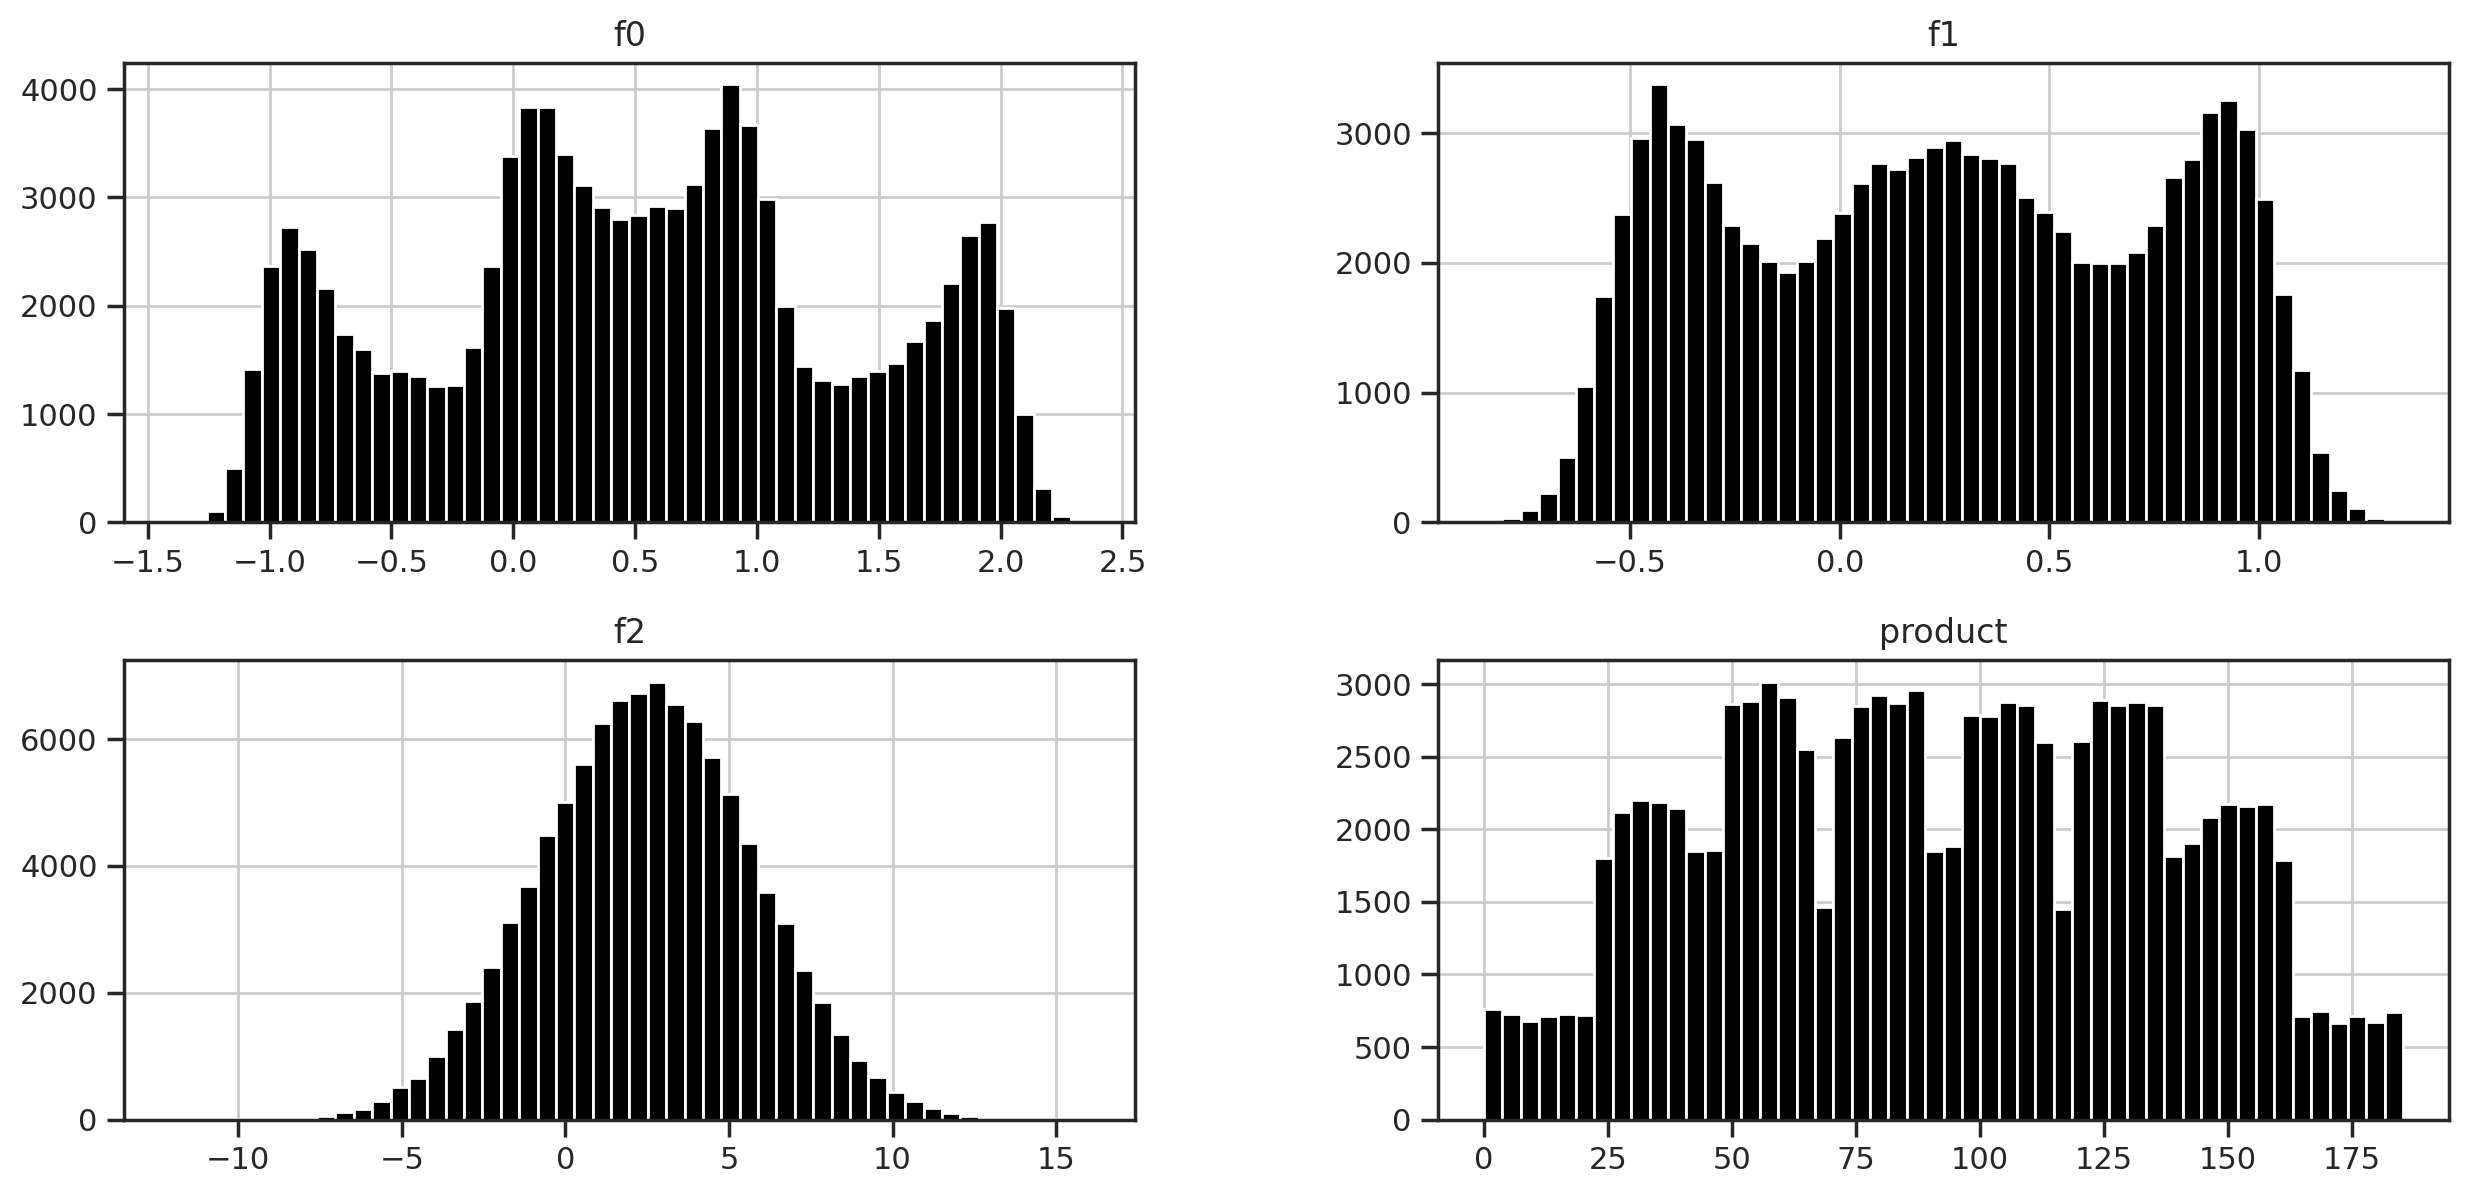

In [5]:
explorer(df1)

,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


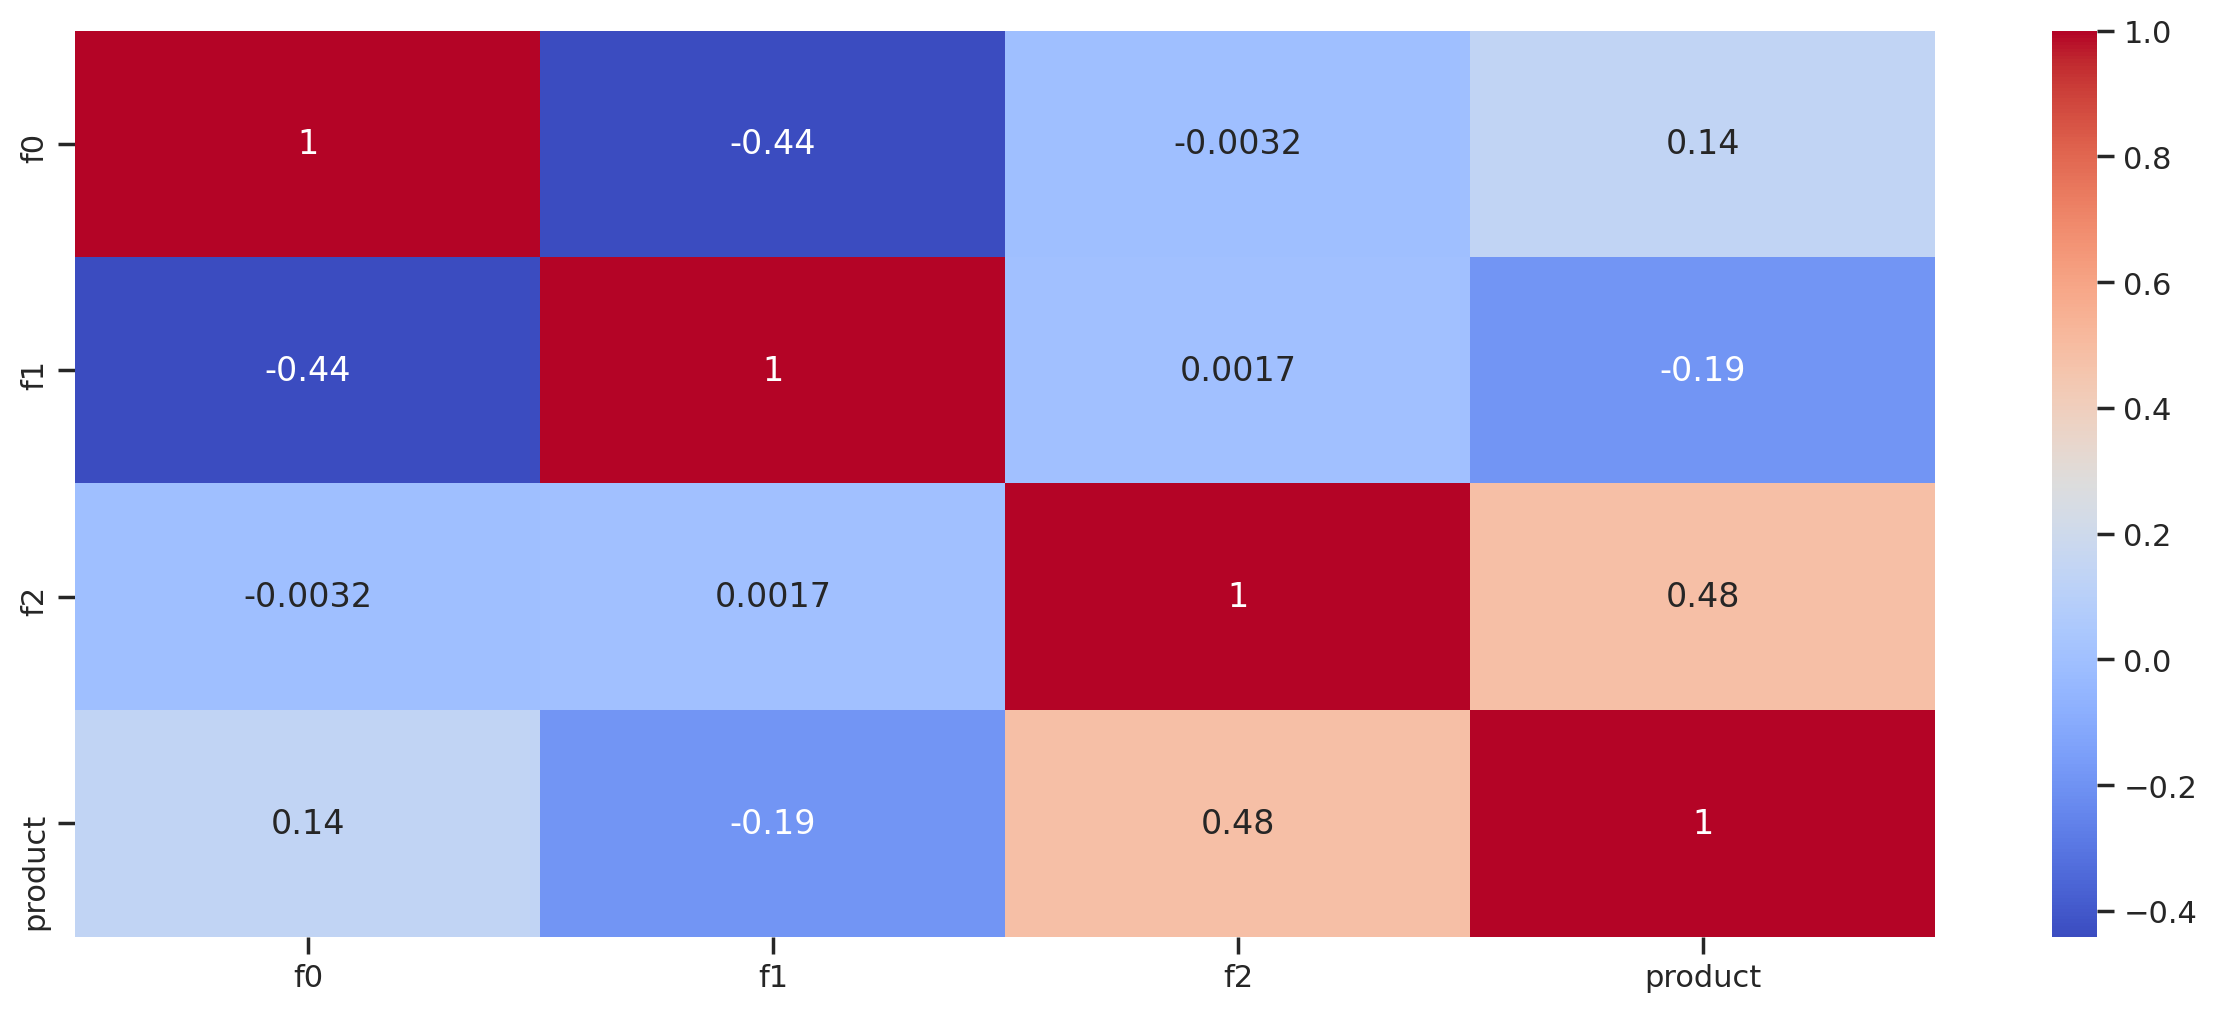

In [6]:
corr_matrix(df1)

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


________________________________________________________________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________________________________________________ 



'Количествово дубликатов:0'

________________________________________________________________________________ 



,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


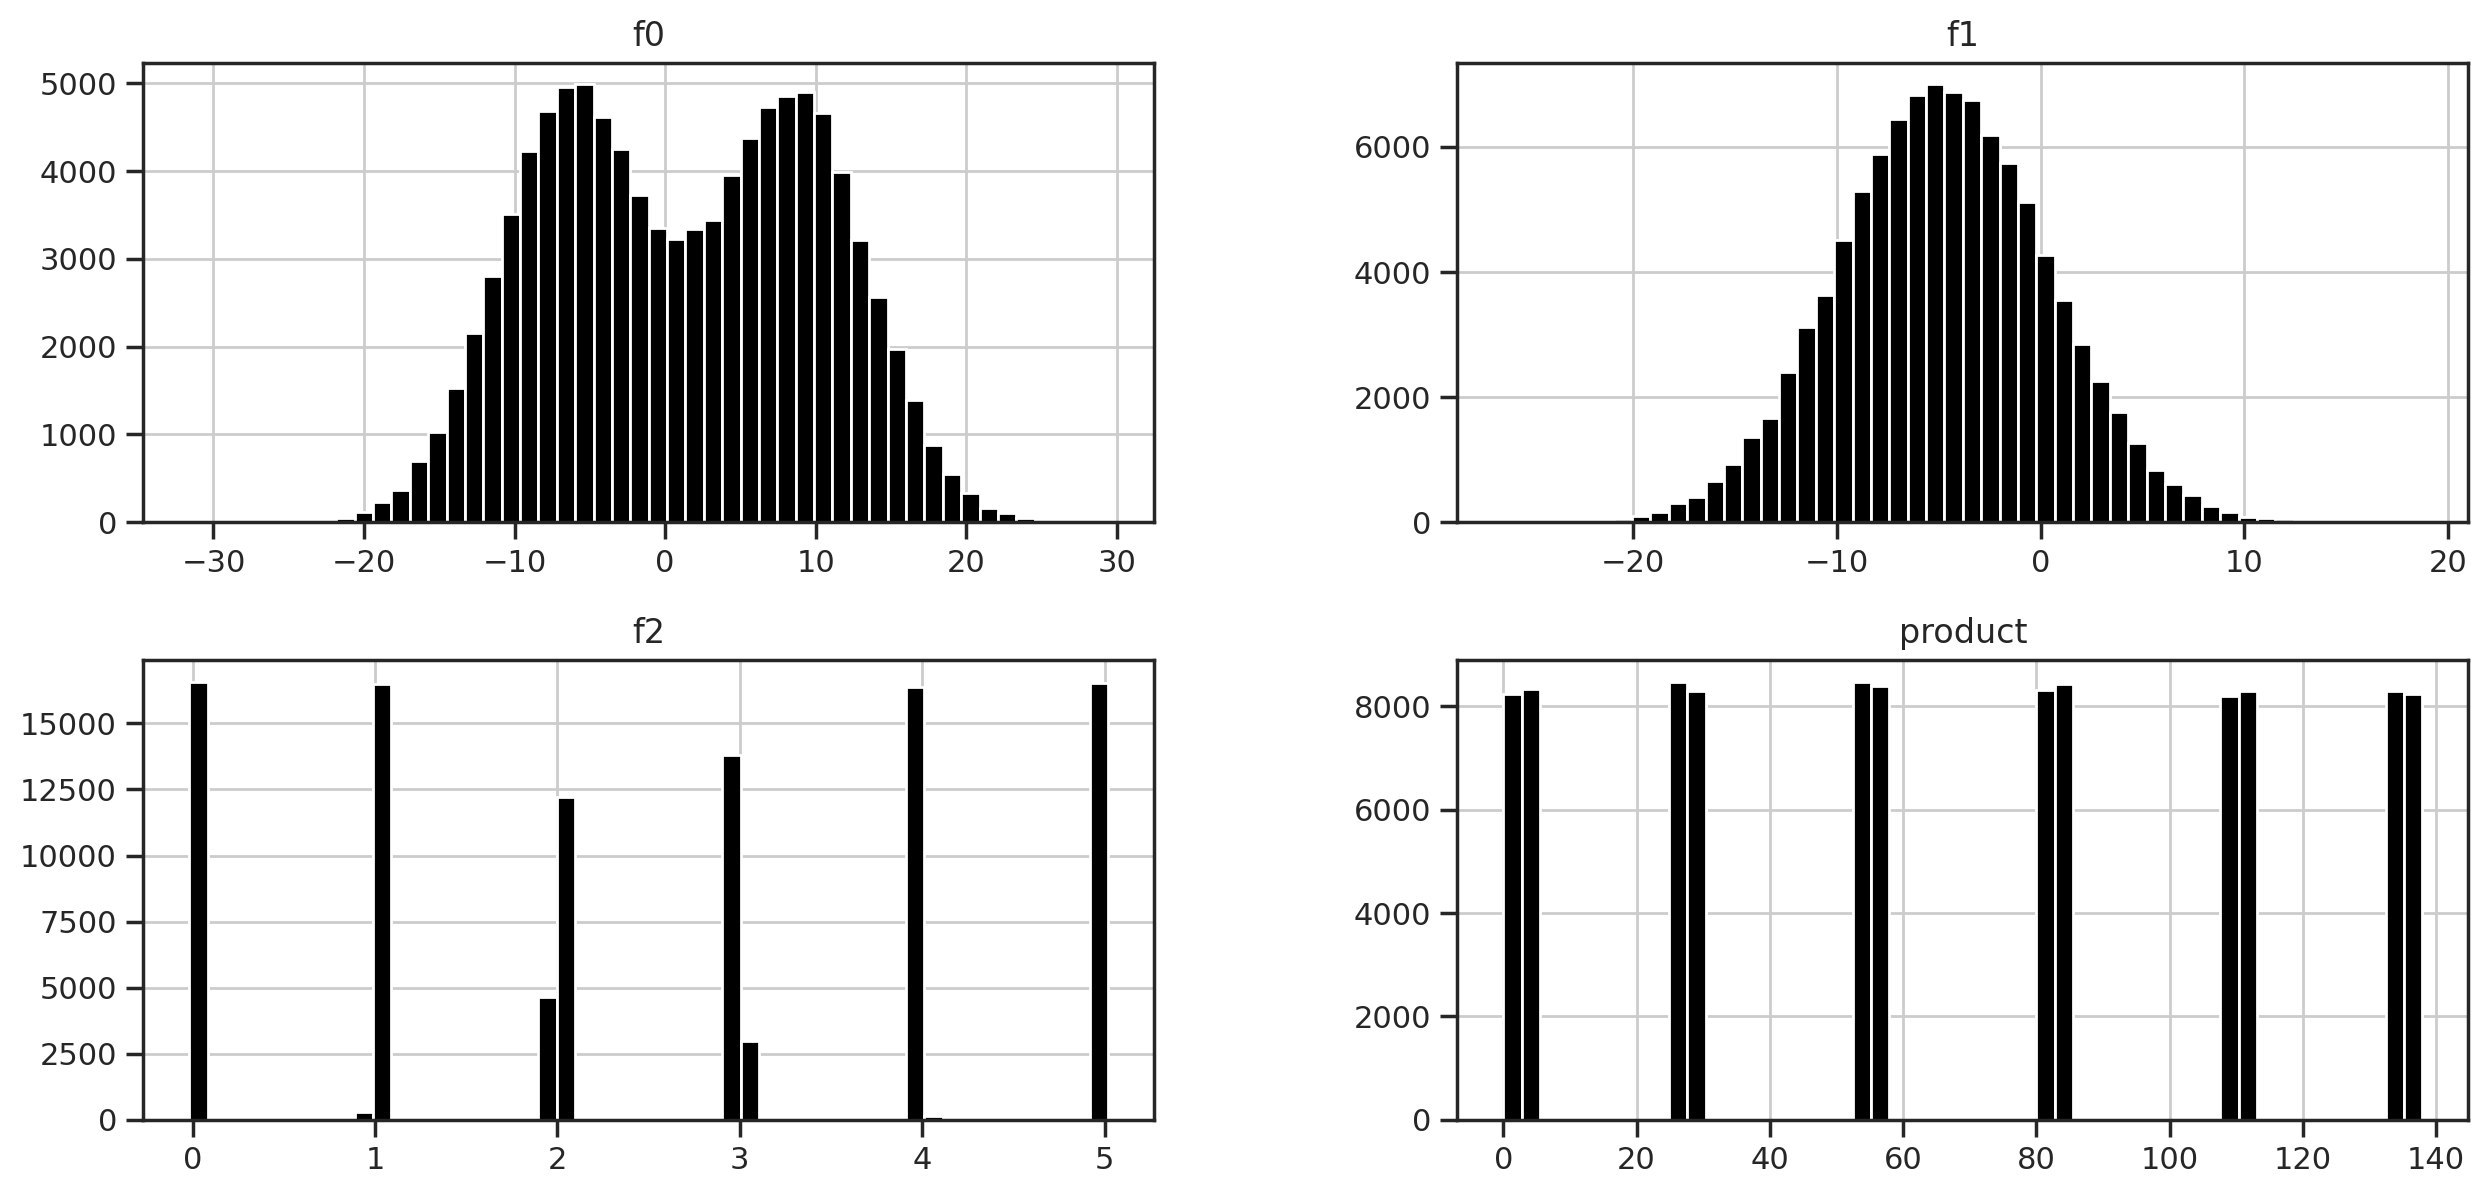

In [7]:
explorer(df2)

,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00


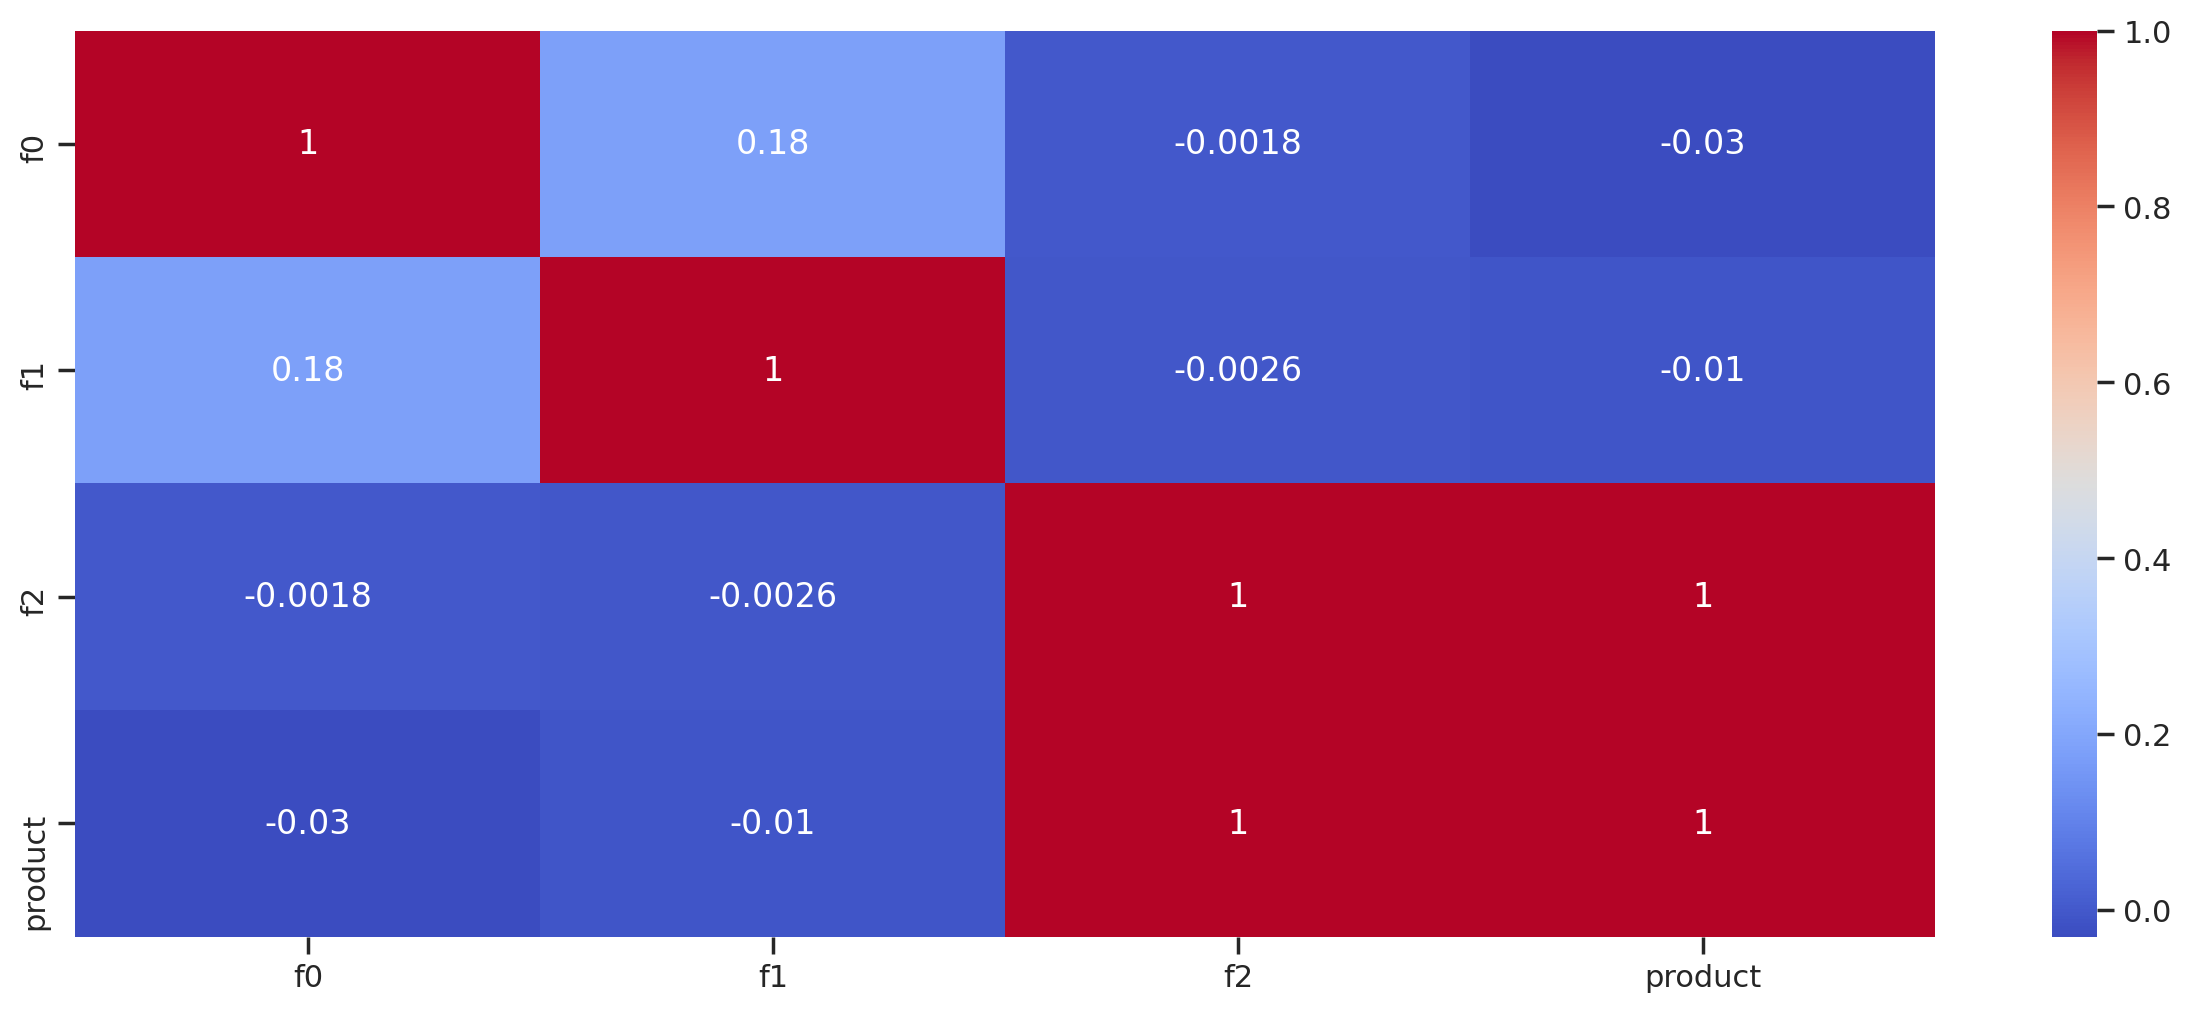

In [8]:
corr_matrix(df2)

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


________________________________________________________________________________ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

________________________________________________________________________________ 



'Количествово дубликатов:0'

________________________________________________________________________________ 



,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


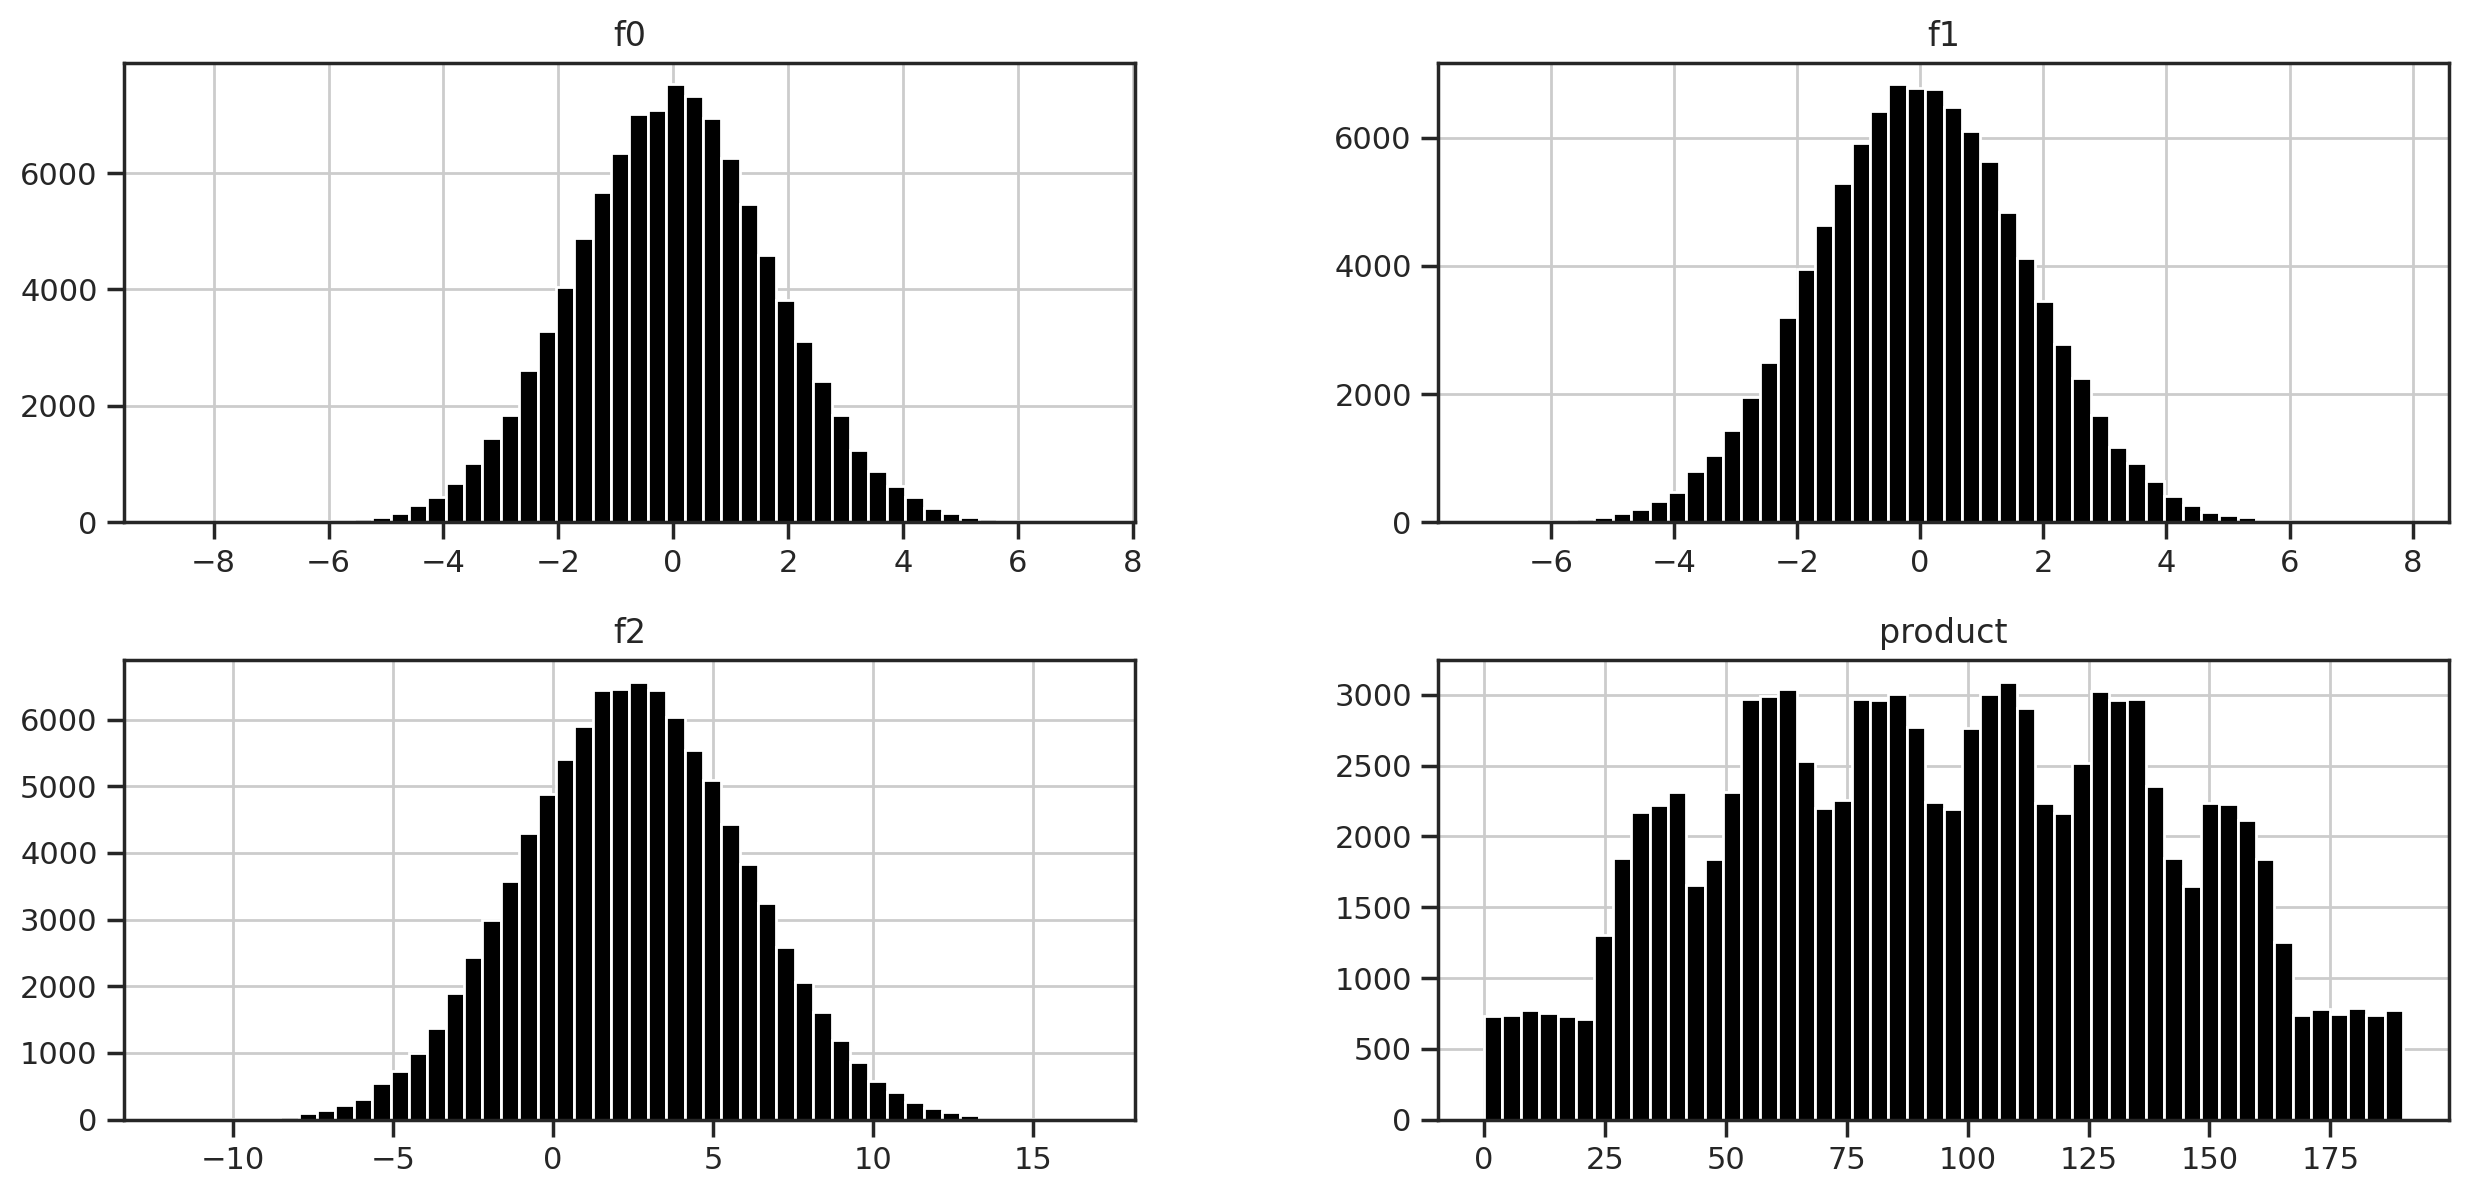

In [9]:
explorer(df3)

,f0,f1,f2,product
f0,1.00,0.00,-0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,-0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00


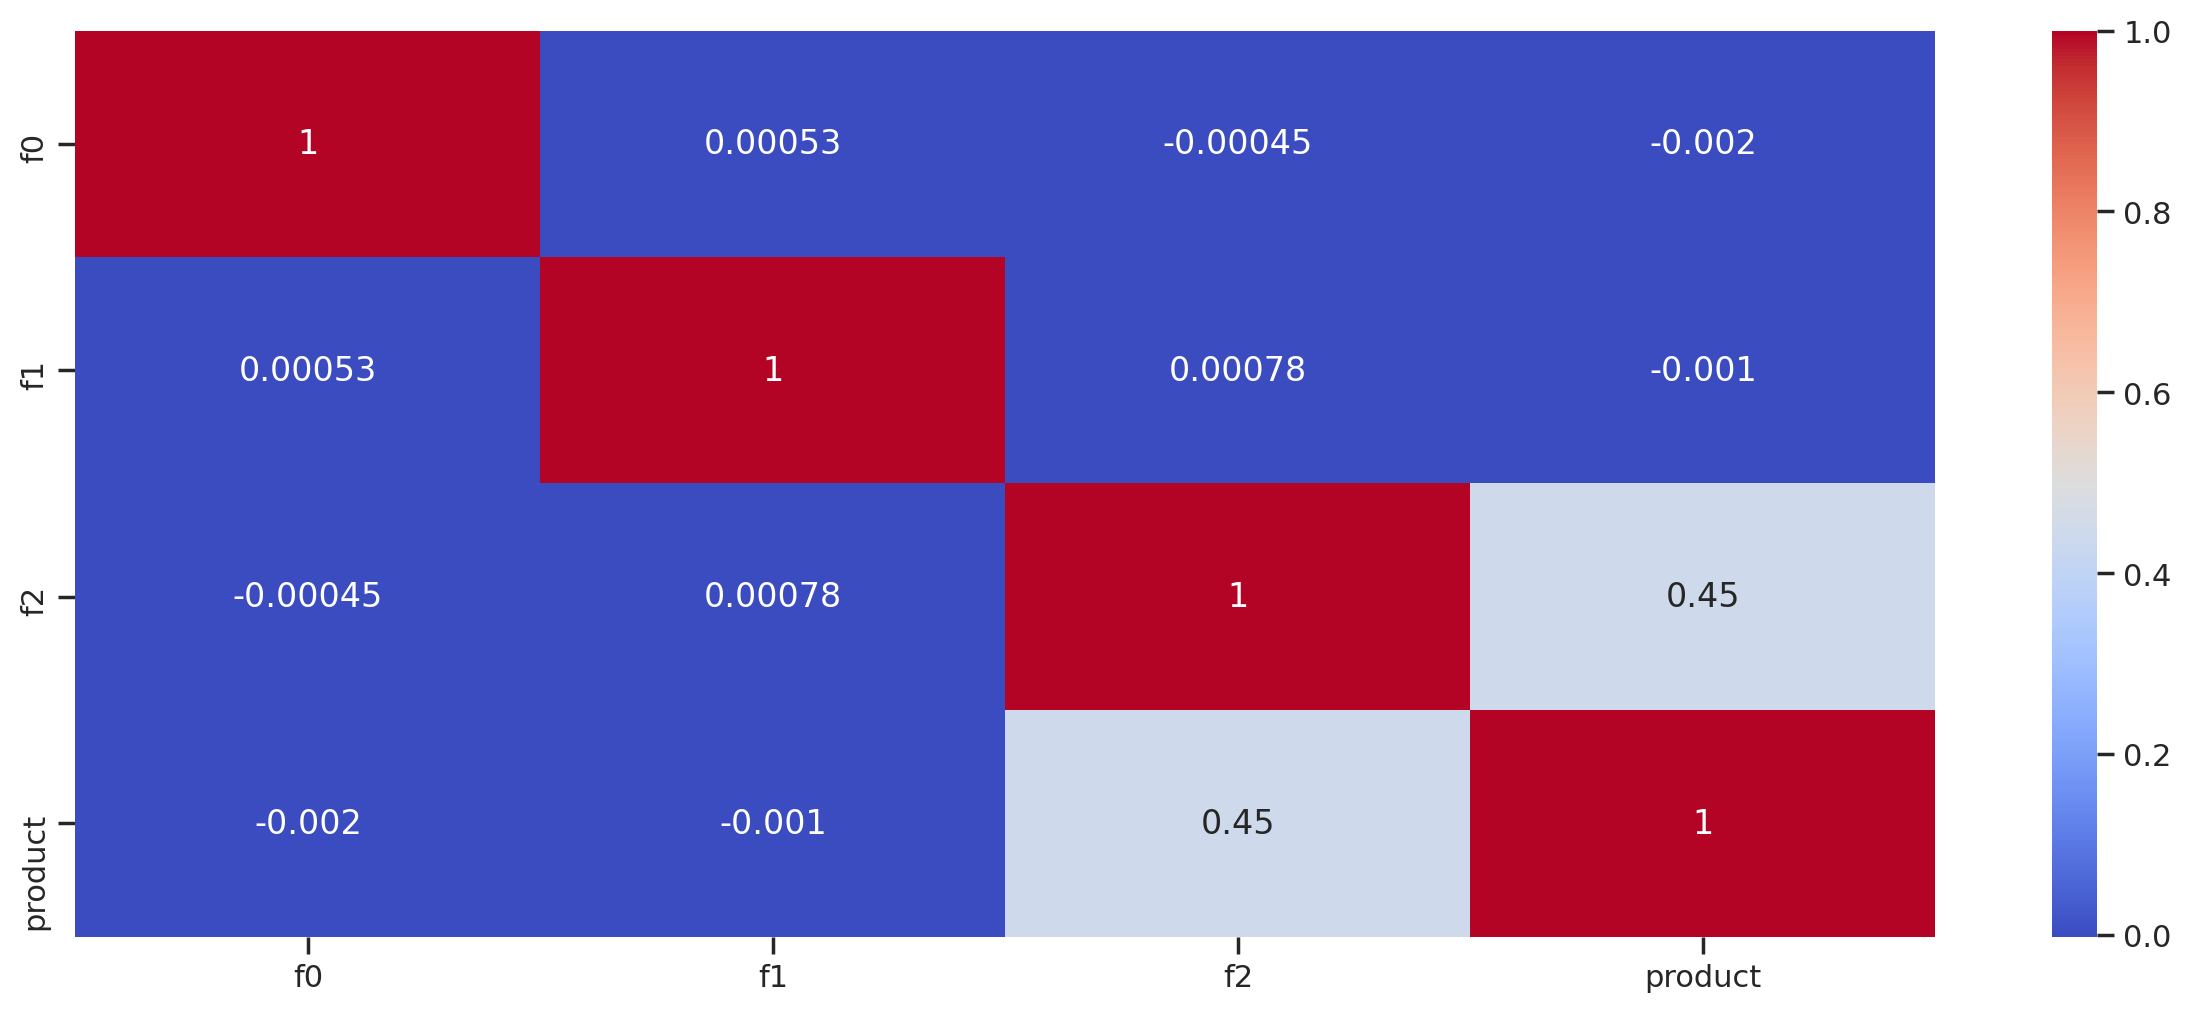

In [10]:
corr_matrix(df3)

<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  

Мы видим, что в трех датасетах отсутствуют дубликаты и по числовым показателям трех датасетов мы можем сделать вывод, что среднее и медиана не имеют большой разницы, кроме столбца `product` в первом датасете, но есть большой разброс значений, который выражен в стандартном отклонении. Особенно ярко это выражено в данных столбцов `f0`, `f1` и `f2`. Однако гистограммы демонстрируют, что распределения переменных существенно различаются для каждого региона. В частности, некоторые аномалии в данных, такие как в столбцах `f2` и `product` в первом датасете, могут препятствовать обучению.

## Обучение и проверка модели

In [11]:
# Удалим из каждого датафрейма столбец id. Он не несет значимости для модели.

df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)
df3 = df3.drop(['id'], axis=1)

In [12]:
names = ['df1', 'df2', 'df3']
data = [df1, df2, df3]

# создадим словарь для хранения фактического и предсказанных значений набора valid
targets = {}

for name, data in zip(names, data):
    target = data['product']
    features = data.drop('product', axis=1)
        
    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size=.25, random_state=state)
    
    # создадим pipeline их скелера и модели линейной регрессии
    model = make_pipeline(StandardScaler(), LinearRegression())
    
    model.fit(features_train, target_train)
    
    # запишем фактические данные и предсказанные в словарь
    targets[name] = (target_valid, pd.Series(model.predict(features_valid), \
                     index=target_valid.index, name='product_predicted'))
    
    # напечатаем на экране средний запас предсказанного сырья и RMSE модели
    print()
    print(f'Для {name} региона:')
    print(f'Средний запас фактического сырья = {targets[name][0].mean():.2f} тыс. баррелей')
    print(f'Средний запас предсказанного сырья = {targets[name][1].mean():.2f} тыс. баррелей')
    print(f'Разница = {(1-targets[name][0].mean()/targets[name][1].mean()):.2%}')
    print(f'RMSE модели = {(mean_squared_error(target_valid, targets[name][1])**0.5):.2f}')


Для df1 региона:
Средний запас фактического сырья = 92.56 тыс. баррелей
Средний запас предсказанного сырья = 92.46 тыс. баррелей
Разница = -0.10%
RMSE модели = 37.89

Для df2 региона:
Средний запас фактического сырья = 69.15 тыс. баррелей
Средний запас предсказанного сырья = 69.14 тыс. баррелей
Разница = -0.01%
RMSE модели = 0.89

Для df3 региона:
Средний запас фактического сырья = 95.08 тыс. баррелей
Средний запас предсказанного сырья = 95.10 тыс. баррелей
Разница = 0.02%
RMSE модели = 40.19


<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
    В данной части работы мы провели обучение и проверку модели. Результаты экспериментов показали, что RMSE (корень из среднеквадратичной ошибки) для датасета `df2` составляет **0.89**. Однако, для датасетов `df1` и `df2`, RMSE значительно выше и составляет **37.58** и **40.03** соответственно. Это говорит о том, что в этих датасетах имеется большой разброс данных в целевых показателях, что означает, что предсказанные значения не отражают реальные запасы сырья с высокой точностью.

## Подготовка к расчёту прибыли

In [13]:
POINTS = 500 # количество скважин, которое исследуют при разведке региона
BEST_FOR_ML = 200 # количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения
BUDGET = 10e9 # бюджет (расходы) на разработку скважин в регионе (тыс. рублей), заложенный на 200 скважин
BARREL_PRICE = 450e3 # доход с каждой единицы продукта (тыс. рублей на 1 тыс. баррелей)
THRESHOLD = 0.025

In [14]:
names = ['df1', 'df2', 'df3']
data = [df1, df2, df3]

break_even = BUDGET / (BARREL_PRICE * BEST_FOR_ML)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even:.2f} тыс. баррелей.')

for name, data in zip(names, data):
    print()
    print(f'Средний запас в {name} регионе = {data["product"].mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше чем порог = {len(data.query("product > @break_even")) / len(data):.2%}')
    print(f'Количество скважин в объёмом больше чем порог = {len(data.query("product > @break_even"))}')

Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в df1 регионе = 92.50 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 36.58%
Количество скважин в объёмом больше чем порог = 36583

Средний запас в df2 регионе = 68.83 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 16.54%
Количество скважин в объёмом больше чем порог = 16537

Средний запас в df3 регионе = 95.00 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 38.18%
Количество скважин в объёмом больше чем порог = 38178


<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
    Для того чтобы окупить вложения в разработку, выбранные моделью скважины должны иметь запасы не менее чем значительно больше пороговой величины, так как процент скважин с запасами выше порога не превышает 40% во всех регионах, при текущих макроусловиях, а точка безубыточности составляет в среднем 111.11 тыс. баррелей на скважину, а средние запасы находятся в диапазоне от 68 до 95 тыс. баррелей на регион. Кроме того, из 500 скважин лишь 200 (40%) имеют запасы выше порога.

## Расчёт прибыли и рисков 

In [15]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)[:count]
    selected = target[probs_sorted.index]
    product = selected.sum()
    revenue = product * BARREL_PRICE
    return revenue - BUDGET

  0%|          | 0/3 [00:00<?, ?it/s]

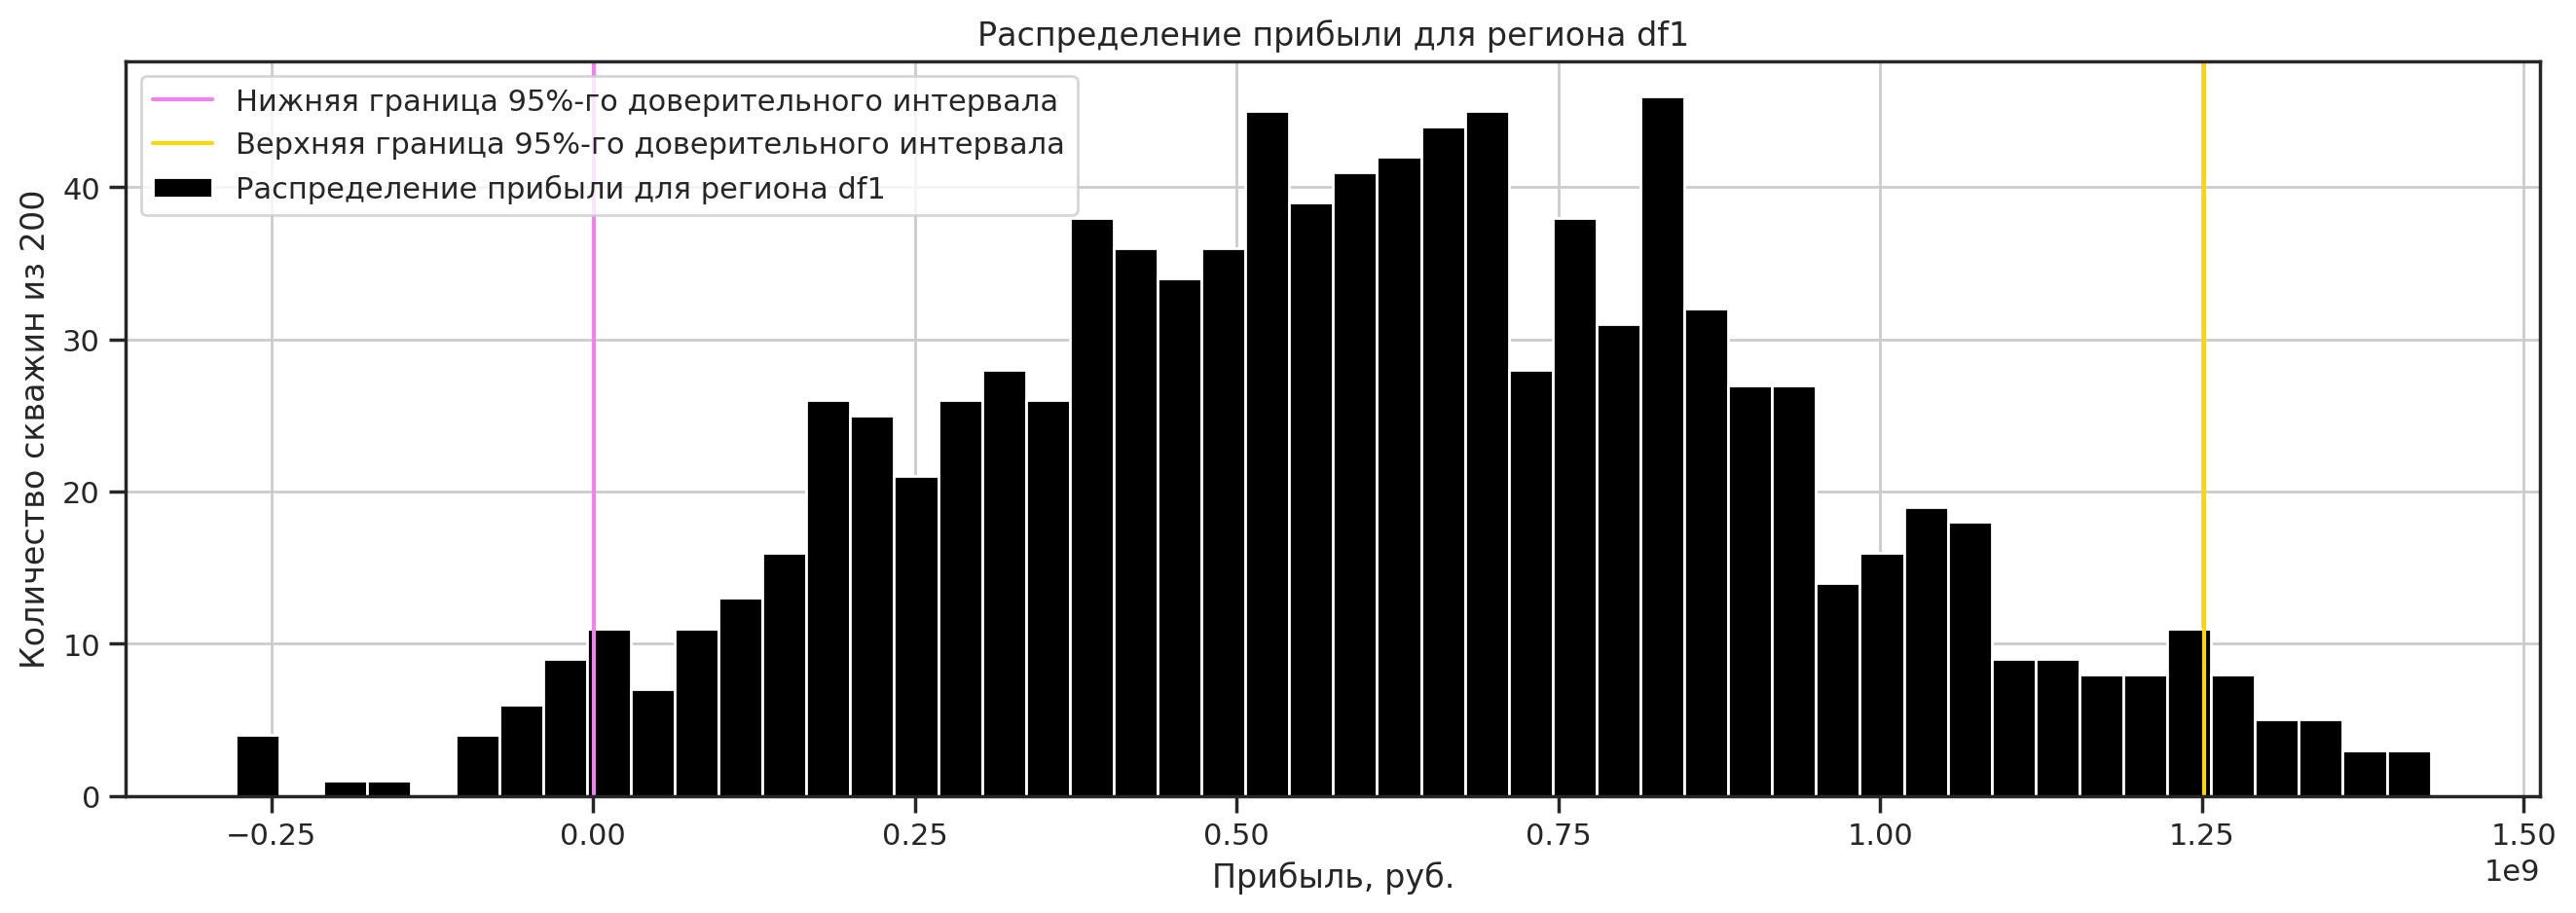


Для df1 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 61 млн. рублей.
Доверительный интервал лежит между 0 - 125 млн. рублей.
Риск убытков составляет = 2.50%


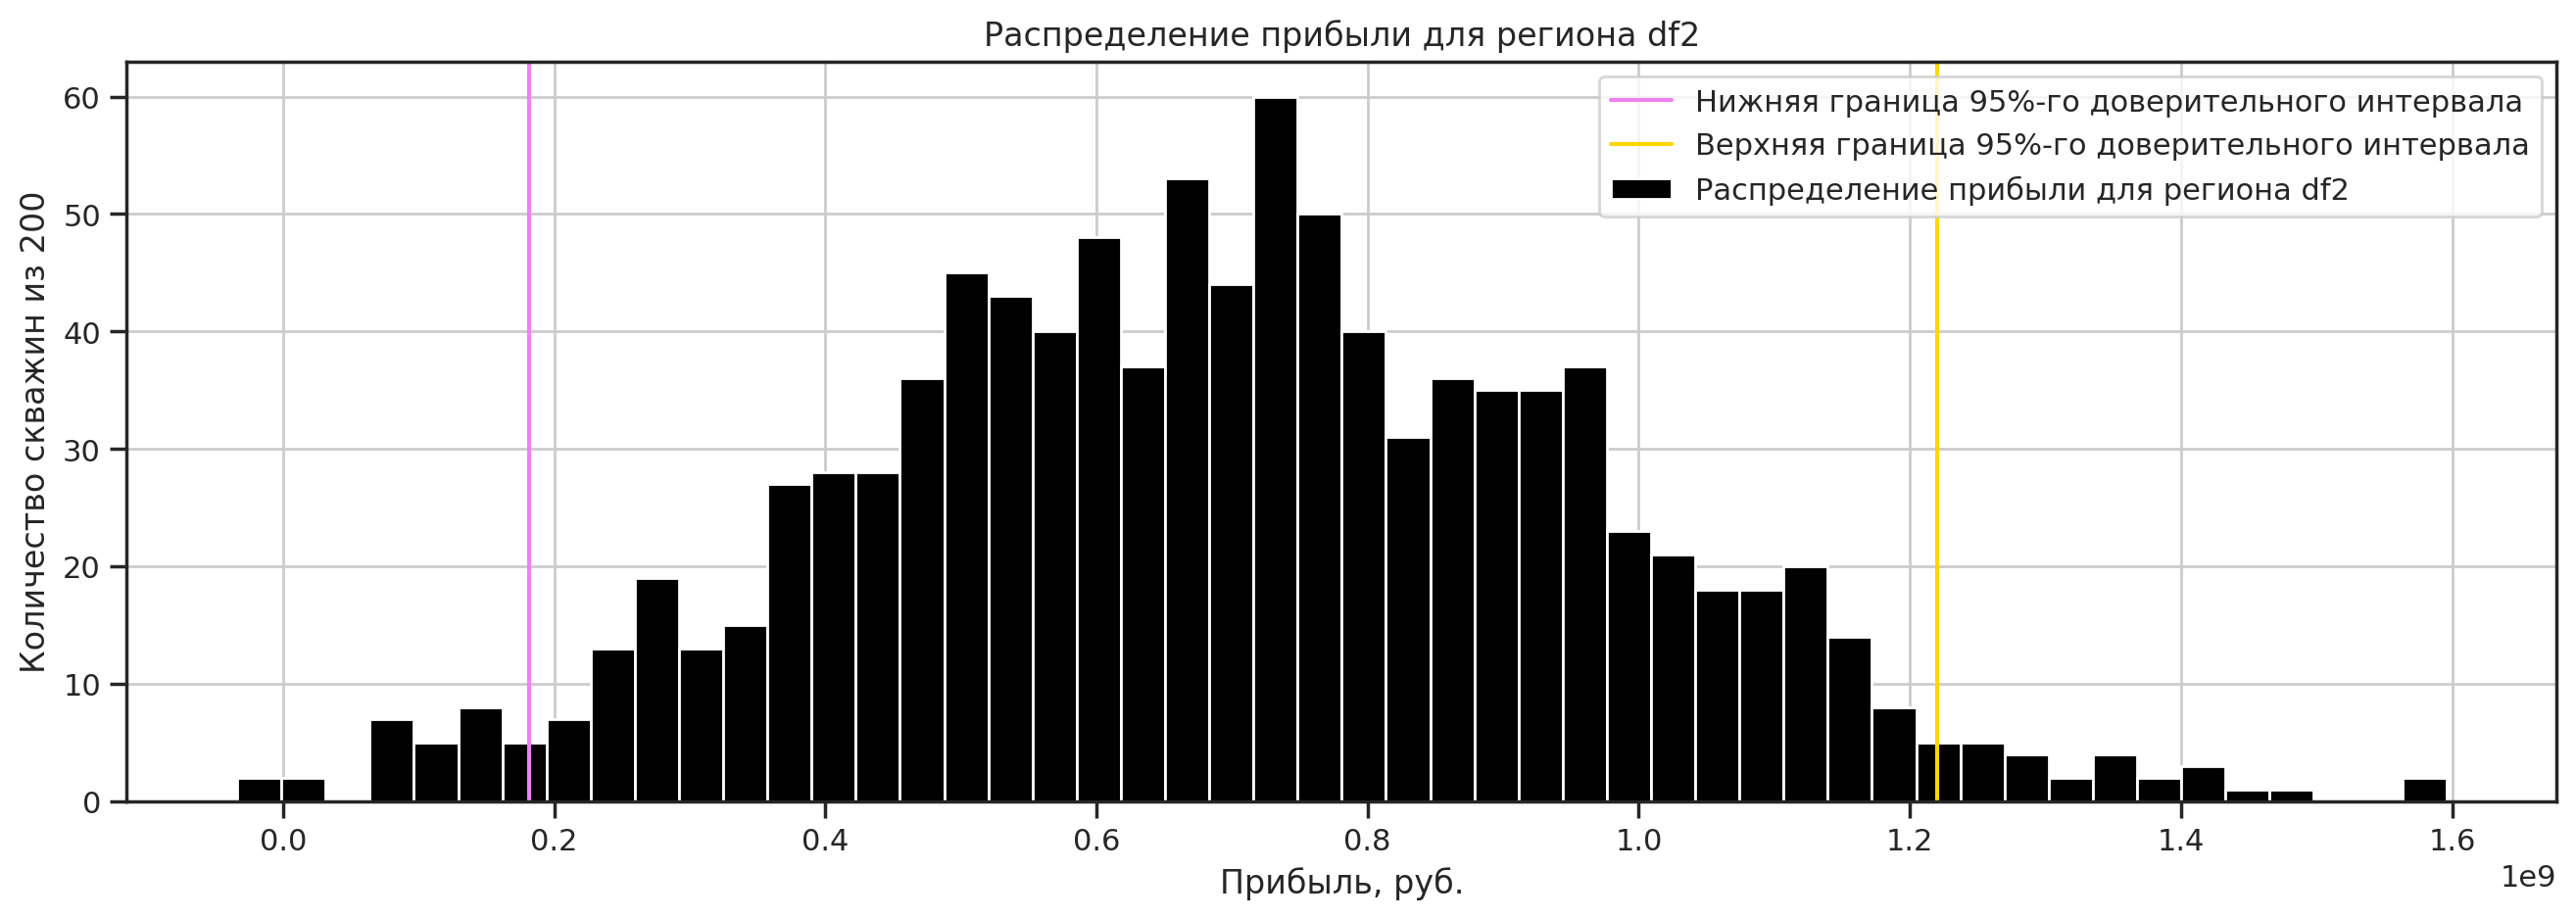


Для df2 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 70 млн. рублей.
Доверительный интервал лежит между 18 - 122 млн. рублей.
Риск убытков составляет = 0.20%


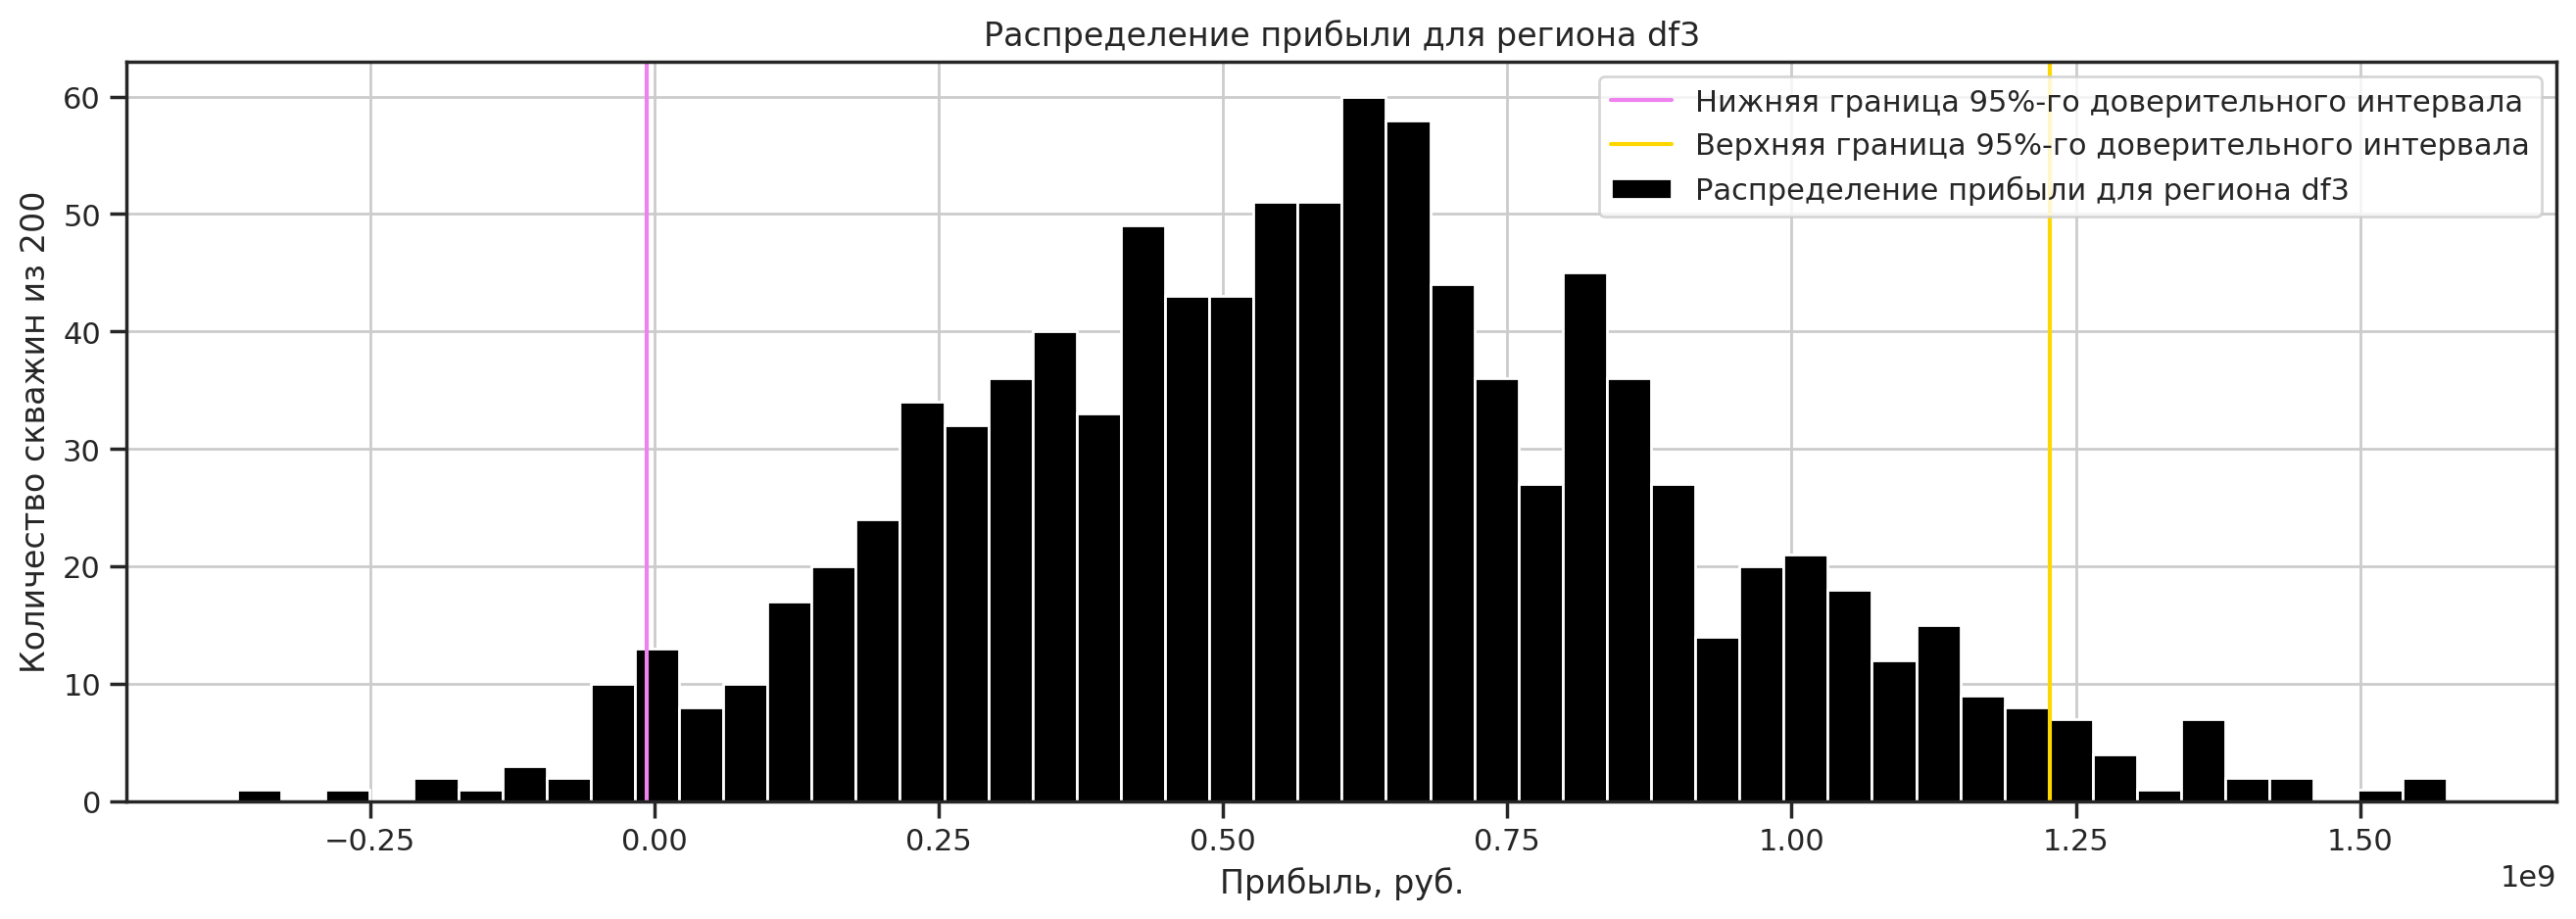


Для df3 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 59 млн. рублей.
Доверительный интервал лежит между -1 - 123 млн. рублей.
Риск убытков составляет = 2.80%


In [16]:
for name in tqdm_notebook(names):
    values = []
    for _ in range(1000):
        target_subsample = targets[name][0].sample(POINTS, replace=True, random_state=state)
        probs_subsample = targets[name][1][target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, BEST_FOR_ML))
        
    values = pd.Series(values)
        
    mean = values.mean() / 10e6
    lower = values.quantile(.025) / 10e6
    upper = values.quantile(.975) / 10e6
    
    risk = values.apply(lambda x: x < 0).sum() / len(values)
    
    # визуализируем
    values.hist(figsize=(16, 5), bins=50, color='black')
    plt.grid(True)
    plt.axvline(values.quantile(0.025), color='violet')
    plt.axvline(values.quantile(0.975), color='gold')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', f'Распределение прибыли для региона {name}'])
    plt.xlabel('Прибыль, руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона {name}')
    plt.show()

    print()
    print(f'Для {name} региона:')
    print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
    print(f'Доверительный интервал лежит между {lower:.0f} - {upper:.0f} млн. рублей.')
    print(f'Риск убытков составляет = {risk:.2%}')

<div style="border:solid black 2px; padding: 10px">  
    
**Комментарий:**  
- В регионе `df2` ожидается наибольшая возможная прибыль в размере 70 млн. рублей при оценке модели.
- Риск потерь минимальный - всего 0,2%, также в первом регионе.
- Регион `df1` может принести наибольшую потенциальную прибыль в размере 125 млн. рублей.
- Учитывая все факторы, можно порекомендовать регион `df2` для разработки, так как он обладает наибольшей средней потенциальной прибылью и минимальными рисками.

## Вывод

<div style="border:solid black 2px; padding: 10px">  
    
1. В начале мы провели исследовательский анализ данных, проверили датасеты на наличие пропусков, дубликатов, а также посмотрели на распределения признаков, которые, в общем, оказались распределены не нормально.  
2. Построили линейную модель, для предсказания объемов нефти в скважинах.  
3. Затем мы выполнили процедуру бутстрэпа и нашли 95% доверительный интервал для среднего объема нефти в скважинах. Наиболее перспективным для разработки представляется регион df2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.  

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован